# Sparkify Project
This is a capstone project to Udacity's Data Scientist Nanodegree. The project is about utilizing Apache Spark to perform Data Science tasks on the ‘Sparkify’ dataset. The Sparkify dataset is a hypothetical user log coming from a music-listening service such as Spotify or Apple Music. The high level goal of the project is to create a prediction model capable of identifying users that are considering to drop their subscription to the music listening service. The music-listening service could utilize the results of the predictive model to send targeted offers in hopes to preserve the user subscription. 

In [1]:
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import udf

from pyspark.sql.types import IntegerType, DateType, StringType, FloatType
from pyspark.sql.functions import desc, asc, udf
from pyspark.sql import functions as func
from pyspark.sql.window import Window

from pyspark.ml.feature import Normalizer, VectorAssembler, MinMaxScaler, StandardScaler, StringIndexer

from pyspark.ml.clustering import KMeans, GaussianMixture
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier


import datetime
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Helper function
def get_unique(df, col_name):
    """Return unique values in a columnn of a df in list format

    Args:
        df (pyspark.DataFrame): Data frame from which to pull uniques
        col_name (str): Name of the column to analyze

    Returns:
        list: Python list of unique values found
    """

    wrapped_unique = df.select(col_name).drop_duplicates().collect()
    uniques = [x.asDict()[col_name] for x in wrapped_unique]
    return uniques


def _get_date(timestamp):
    """
    Args:
        timestamp (str): Time stamp in posix/unix format
        
    Returns:
        str: Time converted to a strong with year, mont, day, hour, minute ans second
    """
    date_str = datetime.datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d:%H%M%S')
    return date_str

# Loading, Exploring and Cleaning Data
We start by printing certain descriptive attributes of the date. Then, records that are invalid, null or repeated are removed

In [4]:
spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .getOrCreate()

In [78]:
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)
user_log.persist()


DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [79]:
user_log.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [80]:
user_log.count()

286500

In [81]:
number_of_records = user_log.count()
print("Number of records before dropping nulls and empty page {}".format(number_of_records))

Number of records before dropping nulls and empty page 286500


In [82]:
# Dropping rows without nans on userId or SessionId. A nan on sessionID means the user hasn't logged in, so we can't tie
# the behavior and pages to any given user, which doesn't help for predicting churn
user_log = user_log.dropna(how="any", subset = ["userId", "sessionId"])

# Dropping users with empty userId
user_log = user_log.filter(user_log["userId"] != "")

# Converting userId to integer for efficiency and consistency
user_log = user_log.withColumn("userId", user_log.userId.cast(IntegerType()))

In [83]:
number_of_records = user_log.count()
print("Number of records after dropping nulls and empty page {}".format(number_of_records))

Number of records after dropping nulls and empty page 278154


In [84]:
# Looking at the columns and data dypes of the dataframe
print(user_log)

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: int]


In [85]:
# Dropping columns that may not help with the goals of the project
columns_to_drop = [
    'userAgent',
    'method',
    'registration',
    'sessionId',
    'gender',
    'firstName',
    'lastName',
    'artist',
    'location',
    'status',
     'soong']
user_log = user_log.drop(*columns_to_drop)


In [86]:
user_log.head()

Row(auth='Logged In', itemInSession=50, length=277.89016, level='paid', page='NextSong', song='Rockpools', ts=1538352117000, userId=30)

# Pre-processing and Data Wrangling

Several steps will reformat the data to enable feature engineering. During these steps, additional data exploration on newly generated or
re-formated data will also take place. This validates the techniques being utilized, and supports feature engineering.

In [87]:
# Finding churn events
churn_flagger = udf(lambda x: 1 if (x == 'Submit Downgrade') | (x == 'Cancellation Confirmation') else 0, IntegerType())
pay_free_flagger = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())
user_log = user_log.withColumn("churn", churn_flagger(user_log.page)).\
            withColumn("pay_or_free", pay_free_flagger(user_log.level))

In [88]:
# Here we assign labels to user as churner or non churner. A churner is someone who downgrades or cancels
binarize = udf(lambda x: 1 if x > 0 else 0, IntegerType())
window_spec = Window.partitionBy("userId")

user_log = user_log.withColumn("churner", func.sum("churn").over(window_spec)).\
           withColumn("payer", func.sum("pay_or_free").over(window_spec))
user_log = user_log.withColumn("payer", binarize(user_log.payer)).\
           withColumn("churner", binarize(user_log.churner))

In [89]:
# Removing users that never got a paid subscription
print("Before removing users that never subbscribed: {}".format(user_log.count()))
user_log = user_log.filter((user_log.payer != 0))
print("After removing users that never subbscribed: {}".format(user_log.count()))

Before removing users that never subbscribed: 278154
After removing users that never subbscribed: 264680


In [90]:
# Showing distribution of page events
page_visit_distribution = user_log.groupBy("page").count()
print("Distribution Event Types")
page_visit_distribution.sort("count").show(page_visit_distribution.count(), False)

Distribution Event Types
+-------------------------+------+
|page                     |count |
+-------------------------+------+
|Cancel                   |36    |
|Cancellation Confirmation|36    |
|Submit Downgrade         |63    |
|Submit Upgrade           |159   |
|Error                    |233   |
|Save Settings            |286   |
|Upgrade                  |416   |
|About                    |478   |
|Help                     |1396  |
|Settings                 |1417  |
|Downgrade                |2055  |
|Thumbs Down              |2386  |
|Roll Advert              |2943  |
|Logout                   |2994  |
|Add Friend               |4065  |
|Add to Playlist          |6259  |
|Home                     |9441  |
|Thumbs Up                |12012 |
|NextSong                 |218005|
+-------------------------+------+



In [91]:
# Converting page to numeric
indexer = StringIndexer(inputCol="page", outputCol="page_label")
user_log = indexer.fit(user_log).transform(user_log)

In [92]:
# Getting a human readable date column so better data exploration could be performed
get_date = udf(lambda x: _get_date(x / 1000.0))
user_log = user_log.withColumn('date', get_date(user_log.ts))

In [93]:
# Showing activity and relevant data for a specific user, sorted by time. This helps us derive activity patterns.
user_log.select(["userId", "page", "level", "ts", "date"]).where(user_log.userId == 100004).sort("ts").collect()

[Row(userId=100004, page='Home', level='free', ts=1538534835000, date='2018-10-03:024715'),
 Row(userId=100004, page='NextSong', level='free', ts=1538534867000, date='2018-10-03:024747'),
 Row(userId=100004, page='NextSong', level='free', ts=1538534975000, date='2018-10-03:024935'),
 Row(userId=100004, page='NextSong', level='free', ts=1538535013000, date='2018-10-03:025013'),
 Row(userId=100004, page='NextSong', level='free', ts=1538535232000, date='2018-10-03:025352'),
 Row(userId=100004, page='NextSong', level='free', ts=1538535414000, date='2018-10-03:025654'),
 Row(userId=100004, page='NextSong', level='free', ts=1538535792000, date='2018-10-03:030312'),
 Row(userId=100004, page='NextSong', level='free', ts=1538536045000, date='2018-10-03:030725'),
 Row(userId=100004, page='Roll Advert', level='free', ts=1538536211000, date='2018-10-03:031011'),
 Row(userId=100004, page='NextSong', level='free', ts=1538536381000, date='2018-10-03:031301'),
 Row(userId=100004, page='NextSong', leve

# Activity visualization

In this section, an activity visualization function is created. It will help visualiza correlations
between activity patterns on a temporal axis.

In [95]:
def create_time_event_vector(df, user, time_start, time_end, to_keep):
    """
    Creates a panda dataframe that could be used to plot filtered events over a time axis
    
    Args:
        df (spark.DataFrame): Dataframe with all data
        user (int): Unique integer user identifier
        time_start (int): in milliseconds, the start of the time window to be filtered
        time_end (int): in milliseconds, the end of the time window to be filtered
        to_keep (str): The string identifier for the page or event
    Return:
        pandas.DataFrame: Data frame that has been filtered, sorted, only a subset of the events
    """
    output = {}
    subset = df.select(["ts", "page_label", "page"]).\
    where((user_log.userId == user)).sort("ts").collect()
    output['ts'] =  [x.asDict()["ts"] for x in subset]
    output['page_label'] = [x.asDict()["page_label"] for x in subset]
    output['page'] = [x.asDict()["page"] for x in subset]
    events_in_time = pd.DataFrame(output).sort_values(by='ts').set_index('page')
    events_in_time = events_in_time.loc[to_keep, :]    
    events_in_time = events_in_time[(events_in_time.ts > time_start) & (events_in_time.ts < time_end)]
    events_in_time = events_in_time.reset_index()
    return events_in_time

In [96]:
# Setting time range for time-series analysis on user 100004
time_start = 1540314019000
time_end = 1540975786000
to_keep = ['NextSong', 'Downgrade', 'Thumbs Up', 'Thumbs Down', 'Submit Downgrade', 'Cancellation Confirmation']
time_event = create_time_event_vector(user_log, 100004, time_start, time_end, to_keep)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [97]:
unique_pages = time_event['page'].unique()
print(unique_pages)

['NextSong' 'Downgrade' 'Thumbs Up' 'Thumbs Down' 'Submit Downgrade']


In [98]:

def plot_events(events_in_time, marks):
    """
    Plots events in a time axis. Each event type has its own marker.
    
    Args:
        events_in_time (pandas.DataFrame): Data frame with the data to be plotted
        marks (list): List of various markers to be iteratively used
    
    """
    fig, ax = plt.subplots()
    fig.set_size_inches((16, 12))

    unique_pages = events_in_time['page'].unique()
    j = 0
    for page in unique_pages:
        records = events_in_time[events_in_time.page==page]
        mark_size = np.ones(len(records))*80
        ax.scatter(records.ts, records.page_label, s=mark_size, marker=marks[j], label=page)
        j=j+1

    ax.set_ylabel('Page Index', fontsize=18)
    ax.set_xlabel('Timestamp', fontsize=18)
    ax.set_title('Event Log', fontsize=18)
    plt.legend()

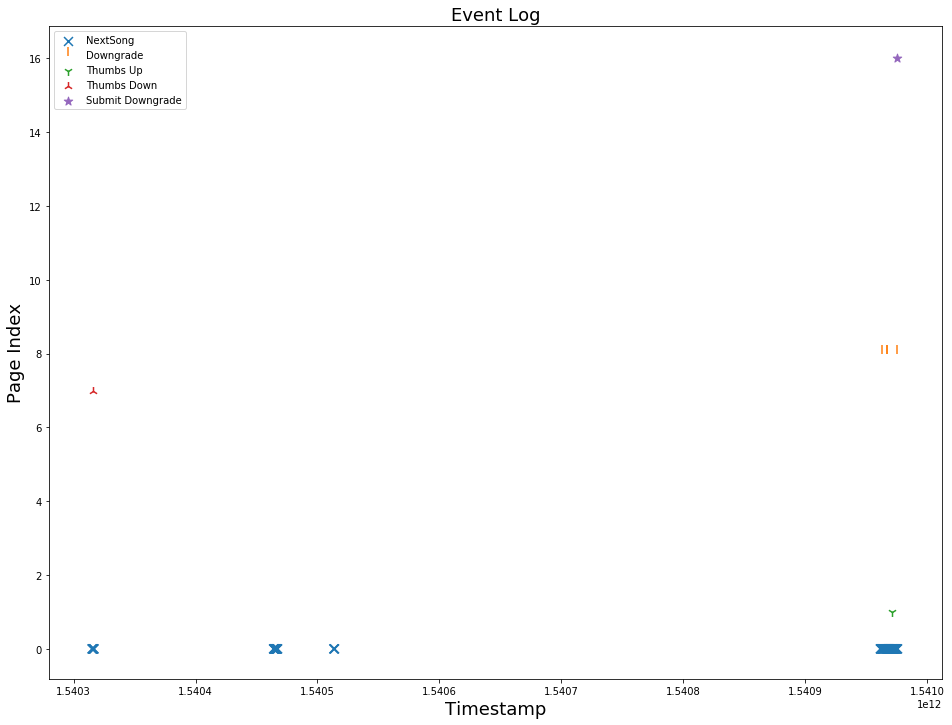

In [24]:
marks = ['x', 2, '1', '2', '*', 'o', 'd', '1', '2', '*', '3', '4', '8', '*', 's', 2, 5, 4, 11, 8, 9, '|']
# Creatinb a story line of events
plot_events(time_event, marks)

In [99]:
# Getting timestamp range (date of first record, date of last record).
# This could provide additional insight/justification for some of the user activity
# Because it could get mapped against seasons.
max_timestamp = user_log.agg({"ts": "max"}).collect()[0]
max_timestamp = max_timestamp.asDict()['max(ts)']
min_timestamp = user_log.agg({"ts": "min"}).collect()[0]
min_timestamp = min_timestamp.asDict()['min(ts)']
earliest_date = _get_date(min_timestamp / 1000.0)
oldest_date = _get_date(max_timestamp / 1000.0)
print(earliest_date)
print(oldest_date)

2018-10-01:000157
2018-12-03:011116


In [100]:
# Categorical features/events are transformed into binary columns

# Looking at a slice for the user 10004, we observed that the 'Downgrade' page is visited before actually downgrading the subscrition.
# This may indicate that the user considered downgrade, but later decided to continue the paid subscription.
# In view of this, visiting the 'Downgrade' page will be captured as a feature.

like_flagger = udf(lambda x: 1 if x == 'Thumbs Up' else 0, IntegerType())
dislike_flagger = udf(lambda x: 1 if x == 'Thumbs Down' else 0, IntegerType())
downgrade_flagger = udf(lambda x: 1 if x == 'Downgrade' else 0, IntegerType())
nextsong_flagger = udf(lambda x: 1 if x == 'NextSong' else 0, IntegerType())

# Creatning hote one encoding for likes, disikes, downgrades and next
user_log = user_log.withColumn("likes", like_flagger(user_log.page)).\
           withColumn("dislikes", dislike_flagger(user_log.page)).\
           withColumn("downgrades", downgrade_flagger(user_log.page)).\
           withColumn("next", nextsong_flagger(user_log.page))

In [101]:
user_log.head()

Row(auth='Logged In', itemInSession=0, length=None, level='free', page='Home', song=None, ts=1538504716000, userId=85, churn=0, pay_or_free=0, churner=1, payer=1, page_label=2.0, date='2018-10-02:182516', likes=0, dislikes=0, downgrades=0, next=0)

# Feature Engineering


In [102]:
# Here, pyspark.sql.window.Window is use to create two temporal sliding windows of 7 and 14 days respectively.
# This window allows to compute 'cumulative activity'. The hypothesis is that whatever leads a user to downgrade or cancel
# a subscribtion would be an accumulation of events that happen recently. In general, all features measure the user
# engagement with the platform. If engagement reduces on a 7 or 14 day window, the user could decide to drop the subscription.

days = lambda i: int(i * 86400*1000)
window_spec_7 = Window.partitionBy("userId").orderBy(func.col("ts").cast('long')).rangeBetween(-days(7), 0)
window_spec_14 = Window.partitionBy("userId").orderBy(func.col("ts").cast('long')).rangeBetween(-days(14), 0)

In [103]:
# Cuumulative events are grouped by likes, dislikes, visits to downgrade/cancel subscription pages.
# All of these are considered potential indicators that churn will happen or is about to happen.
user_log_for_ml = user_log.\
                  withColumn("acu_dislikes_7", func.sum("dislikes").over(window_spec_7)).\
                  withColumn("acu_downgrade_7", func.sum("downgrades").over(window_spec_7)).\
                  withColumn("acu_next_7", func.sum("next").over(window_spec_7)).\
                  withColumn("acu_dislikes_14", func.sum("dislikes").over(window_spec_14)).\
                  withColumn("acu_downgrade_14", func.sum("downgrades").over(window_spec_14)).\
                  withColumn("acu_next_14", func.sum("next").over(window_spec_14)).\
                  select(["userId", "acu_dislikes_7", "acu_downgrade_7", "acu_next_7", \
                          "acu_dislikes_14", "acu_downgrade_14", "acu_next_14", "churner"])

user_log_for_ml.persist()

DataFrame[userId: int, acu_dislikes_7: bigint, acu_downgrade_7: bigint, acu_next_7: bigint, acu_dislikes_14: bigint, acu_downgrade_14: bigint, acu_next_14: bigint, churner: int]

In [104]:
# Ensuring both classes are represented equally (avoid class inbalance). Two separate frames are created, one for churners
# and one for non churners. Then we fill up a combined frame that has the same number of churners as non churners.
user_log_for_ml_churners = user_log_for_ml.filter(user_log.churn == 1)
churner_count = user_log_for_ml_churners.count()

user_log_for_ml_nonchurners = user_log_for_ml.filter(user_log.churner == 0)
nonchurner_count = user_log_for_ml_nonchurners.count()

# This line combines the full set of churners with a set of non-churners of the same size. The non-churners are randomly
# sampled from the full set of non-churners. The sample size is determined by taking the ratio of total number of churners
# over the non-churners. The end goal is to have both classes equally represented.
user_log_for_ml = user_log_for_ml_churners.union(user_log_for_ml_nonchurners.sample(churner_count/nonchurner_count))

In [105]:
user_log_for_ml_churners.select('userId').drop_duplicates().count()

76

In [106]:
user_log_for_ml_nonchurners.select('userId').drop_duplicates().count()

89

In [107]:
# The activity distribution compares the statistics of the features for both churners and non churners
activity_distribution = user_log_for_ml.groupBy("churner").\
                        avg("acu_downgrade_7",
                            "acu_downgrade_14",
                            "acu_next_7",
                            "acu_next_14",
                           "acu_dislikes_7",
                           "acu_dislikes_14")

In [108]:
# Difference on the statistics between churners and non churners demonstrates that these features should work. 
# It would be possible to distinguish between the 2 classes with these features
activity_distribution.show()

+-------+--------------------+---------------------+------------------+-----------------+-------------------+--------------------+
|churner|avg(acu_downgrade_7)|avg(acu_downgrade_14)|   avg(acu_next_7)| avg(acu_next_14)|avg(acu_dislikes_7)|avg(acu_dislikes_14)|
+-------+--------------------+---------------------+------------------+-----------------+-------------------+--------------------+
|      1|   4.797979797979798|    6.959595959595959|356.55555555555554|561.8787878787879|  4.171717171717172|   6.626262626262626|
|      0|  2.7745098039215685|   3.7450980392156863| 255.7450980392157|385.8921568627451| 2.3137254901960786|  3.3823529411764706|
+-------+--------------------+---------------------+------------------+-----------------+-------------------+--------------------+



In [109]:
# Creating the feature vectors. Twwo sets are created. Set A and Set B.
feat_assembler_a = VectorAssembler(inputCols=["acu_downgrade_7"], outputCol="features_a", handleInvalid='skip')
feat_assembler_b = VectorAssembler(
    inputCols=["acu_downgrade_7", "acu_downgrade_14",  "acu_next_7", "acu_next_14", "acu_dislikes_7", "acu_dislikes_14"],
    outputCol="features_b")
# Accumulated visits to Dowgrade Page over 7 day windows
user_log_for_ml = feat_assembler_a.transform(user_log_for_ml)
# Accumulated visits to downgrade, nextsong, tumbup, thumbdown over both 7 and 14 day windows
user_log_for_ml = feat_assembler_b.transform(user_log_for_ml)

In [110]:
# Applying MinMax Scaling to features_a
scaler_a = MinMaxScaler(inputCol="features_a", outputCol="nrm_features_a")
user_log_for_ml = scaler_a.fit(user_log_for_ml).transform(user_log_for_ml)

In [111]:
# Applying StandardScaler to features_b
scaler_b = StandardScaler(inputCol="features_b", outputCol="nrm_features_b")
user_log_for_ml = scaler_b.fit(user_log_for_ml).transform(user_log_for_ml)


# Modeling
Spliting the full dataset into train, test, and validation sets. Testing out several machine learning algorithms. Tunning model parameters and evaluating and comparing the accuracy of the various models. The best performing model is tested with validation data as the final result.

In [117]:
# Helps with always getting the sample samples when random samplin occurs
# Reference: https://medium.com/udemy-engineering/pyspark-under-the-hood-randomsplit-and-sample-inconsistencies-examined-7c6ec62644bc
user_log_for_ml.persist(pyspark.StorageLevel.MEMORY_AND_DISK)
# Splitting Data in two groups, larger groups is used for training
train_dat, test_val_dat = user_log_for_ml.randomSplit([0.75, 0.25], seed=7)
# Smaller group is further split in two, test and validation, both of the same size
test_dat, val_dat = test_val_dat.randomSplit([0.5, 0.5], seed=7)

In [119]:
# Speed things up a bit
train_dat.persist(pyspark.StorageLevel.MEMORY_AND_DISK)
test_dat.persist(pyspark.StorageLevel.MEMORY_AND_DISK)
val_dat.persist(pyspark.StorageLevel.MEMORY_AND_DISK)

DataFrame[userId: int, acu_dislikes_7: bigint, acu_downgrade_7: bigint, acu_next_7: bigint, acu_dislikes_14: bigint, acu_downgrade_14: bigint, acu_next_14: bigint, churner: int, features_a: vector, features_b: vector, nrm_features_a: vector, nrm_features_b: vector]

In [ ]:
# Verifying counts on each of the groups
print(train_dat.count())
print(test_dat.count())
print(val_dat.count())

In [40]:
def tonumpy(df, column_name):
    """
    Pulls a column out of a pyspark data frame, and returns it as a numpy vector.
    Speed things up for small calculations.
    
    Args:
       df (pyspark.DataFrame): Data Frame to be proccesed
    """
    return np.array(df.select(column_name).rdd.flatMap(lambda x: x).collect())

In [41]:
# Structures will be used to store results on a more efficient object
test_results_feat_a = {'truth_labels': [], 'log_reg_labels': [], 'rnd_forest_labels': [], 'dec_tree_labels': []}
test_results_feat_b = {'truth_labels': [], 'log_reg_labels': [], 'rnd_forest_labels': [], 'dec_tree_labels': []}

In [43]:
# Getting truth labels for test and validation labels
test_truth = tonumpy(test_dat, 'churner')
val_truth = tonumpy(val_data, 'churner')

In [43]:
# Training Logistic Regression on nrm_features_a and passing test_dat for inference
log_reg_obj_a = LogisticRegression(featuresCol="nrm_features_a", labelCol="churner", predictionCol='logr_pred_a')
log_reg_model_a = log_reg_obj_a.fit(train_dat)
results= log_reg_model_a.transform(test_dat)

In [44]:
# Computing performance metrics
test_results_feat_a['truth_labels'] = test_truth
test_results_feat_a['log_reg_labels'] = tonumpy(results, 'logr_pred_a')

accuracy = sum(test_results_feat_a['truth_labels'] == test_results_feat_a['log_reg_labels'])/len(test_results_feat_a['truth_labels'])
print("Accuracy for LogisticRegression with nrm_features_a {}".format(accuracy))
print()
print("Classification Report for LogisticRegression with nrm_features_a")
print(classification_report(test_results_feat_a['truth_labels'], test_results_feat_a['log_reg_labels']))

Accuracy for LogisticRegression with nrm_features_a 0.6363636363636364

Classification Report for LogisticRegression with nrm_features_a
             precision    recall  f1-score   support

          0       0.75      0.50      0.60         6
          1       0.57      0.80      0.67         5

avg / total       0.67      0.64      0.63        11



In [45]:
# Training Logistic Regression on nrm_features_b and passing test_dat for inference
log_reg_obj_b = LogisticRegression(featuresCol="nrm_features_b", labelCol="churner", predictionCol='logr_pred_b')
log_reg_model_b = log_reg_obj_b.fit(train_dat)
results= log_reg_model_b.transform(test_dat)

In [46]:
# Computing performance metrics
test_results_feat_b['truth_labels'] = test_truth
test_results_feat_b['log_reg_labels']= tonumpy(results, 'logr_pred_b')

accuracy = sum(test_results_feat_b['truth_labels'] == test_results_feat_b['log_reg_labels'])/len(test_results_feat_b['truth_labels'])
print("Accuracy for LogisticRegression with nrm_features_b {}".format(accuracy))
print()
print("Classification Report for LogisticRegression with nrm_features_b")
print(classification_report(test_results_feat_b['truth_labels'], test_results_feat_b['log_reg_labels']))

Accuracy for LogisticRegression with nrm_features_b 0.5454545454545454

Classification Report for LogisticRegression with nrm_features_b
             precision    recall  f1-score   support

          0       0.57      0.67      0.62         6
          1       0.50      0.40      0.44         5

avg / total       0.54      0.55      0.54        11



In [45]:
# Training Random Forest Classifier on nrm_features_a
rand_for_obj_a = RandomForestClassifier(featuresCol="nrm_features_a", labelCol="churner", predictionCol='rand_for_pred_a')
rand_for_model_a = rand_for_obj_a.fit(train_dat)
results = rand_for_model_a.transform(test_dat)

In [46]:
# Computing performance metrics
test_results_feat_a['truth_labels'] = test_truth
test_results_feat_a['rnd_forest_labels'] = tonumpy(results, 'rand_for_pred_a')

accuracy = sum(test_results_feat_a['truth_labels'] == test_results_feat_a['rnd_forest_labels'])/len(test_results_feat_a['truth_labels'])
print("Accuracy for RandomForest with nrm_features_a {}".format(accuracy))
print()
print("Classification Report for RandomForest with nrm_features_a")
print(classification_report(test_results_feat_a['truth_labels'], test_results_feat_a['rnd_forest_labels']))

Accuracy for RandomForest with nrm_features_a 0.5454545454545454

Classification Report for RandomForest with nrm_features_a
             precision    recall  f1-score   support

          0       0.67      0.33      0.44         6
          1       0.50      0.80      0.62         5

avg / total       0.59      0.55      0.52        11



In [48]:
# Training Random Forest Classifier on nrm_features_b
rand_for_obj_b = RandomForestClassifier(featuresCol="nrm_features_b", labelCol="churner", predictionCol='rand_for_pred_b')
rand_for_model_b = rand_for_obj_b.fit(train_dat)
results = rand_for_model_b.transform(test_dat)

In [49]:
# Computing performance metrics
test_results_feat_b['truth_labels'] = test_truth
test_results_feat_b['rnd_forest_labels'] = tonumpy(results, 'rand_for_pred_b')

accuracy = sum(test_results_feat_b['truth_labels'] == test_results_feat_b['rnd_forest_labels'])/len(test_results_feat_b['truth_labels'])
print("Accuracy for RandomForest with nrm_features_b {}".format(accuracy))
print()
print("Classification Report for RandomForest with nrm_features_b")
print(classification_report(test_results_feat_b['truth_labels'], test_results_feat_b['rnd_forest_labels']))

Accuracy for RandomForest with nrm_features_b 0.45454545454545453

Classification Report for RandomForest with nrm_features_b
             precision    recall  f1-score   support

          0       0.50      0.33      0.40         6
          1       0.43      0.60      0.50         5

avg / total       0.47      0.45      0.45        11



In [50]:
# Training Decision Tree Classifier on nrm_features_a
dec_tree_obj_a = DecisionTreeClassifier(featuresCol="nrm_features_a", labelCol="churner", predictionCol='dec_tree_pred_a')
dec_tree_model_a = dec_tree_obj_a.fit(train_dat)
results = dec_tree_model_a.transform(test_dat)

In [51]:
# Computing performance metrics
test_results_feat_a['truth_labels'] = test_truth
test_results_feat_a['dec_tree_labels'] = tonumpy(results, 'dec_tree_pred_a')

accuracy = sum(test_results_feat_a['truth_labels'] == test_results_feat_a['dec_tree_labels'])/len(test_results_feat_a['truth_labels'])
print("Accuracy for RandomForest with nrm_features_a {}".format(accuracy))
print()
print("Classification Report for RandomForest with nrm_features_a")
print(classification_report(test_results_feat_a['truth_labels'], test_results_feat_a['dec_tree_labels']))

Accuracy for RandomForest with nrm_features_a 0.5454545454545454

Classification Report for RandomForest with nrm_features_a
             precision    recall  f1-score   support

          0       0.67      0.33      0.44         6
          1       0.50      0.80      0.62         5

avg / total       0.59      0.55      0.52        11



In [52]:
# Training Decision Tree Classifier on nrm_features_b
dec_tree_obj_b = DecisionTreeClassifier(featuresCol="nrm_features_b", labelCol="churner", predictionCol='dec_tree_pred_b')
dec_tree_model_b = dec_tree_obj_b.fit(train_dat)
results= dec_tree_model_b.transform(test_dat)

In [53]:
# Computing performance metrics
test_results_feat_b['truth_labels'] = test_truth
test_results_feat_b['dec_tree_labels'] = tonumpy(results, 'dec_tree_pred_b')

accuracy = sum(test_results_feat_b['truth_labels'] == test_results_feat_b['dec_tree_labels'])/len(test_results_feat_b['truth_labels'])
print("Accuracy for RandomForest with nrm_features_b {}".format(accuracy))

print("Classification Report for RandomForest with nrm_features_b")
print(classification_report(test_results_feat_b['truth_labels'], test_results_feat_b['dec_tree_labels']))



Accuracy for RandomForest with nrm_features_b 0.6363636363636364
Classification Report for RandomForest with nrm_features_b
             precision    recall  f1-score   support

          0       0.67      0.67      0.67         6
          1       0.60      0.60      0.60         5

avg / total       0.64      0.64      0.64        11



In [54]:
# Creating a new feature set with accumulation of dowgrade and dislike visits over 7 day windows
feat_assembler_c = VectorAssembler(inputCols=["acu_downgrade_7", "acu_dislikes_7"], outputCol="features_c", handleInvalid='skip')
user_log_for_ml = feat_assembler_c.transform(user_log_for_ml)


In [55]:
# Applying MinMaxScaler to features_c
scaler_c = MinMaxScaler(inputCol="features_c", outputCol="nrm_features_c")

# Features are now columns of the user_log_for_ml
user_log_for_ml = scaler_c.fit(user_log_for_ml).transform(user_log_for_ml)

In [56]:
# Creating a test, train, validation split on the data, but this time it includes nrm_features_c

train_dat, test_val_dat = user_log_for_ml.randomSplit([0.75, 0.25], seed=7)
test_dat, val_data = test_val_dat.randomSplit([0.5, 0.5], seed=7)

In [57]:
# Training Decision Tree Classifier with nrm_features_c, feeding it test_Dat
dec_tree_obj_c = DecisionTreeClassifier(featuresCol="nrm_features_c", labelCol="churner", predictionCol='dec_tree_pred_c')
dec_tree_model_c = dec_tree_obj_c.fit(train_dat)
results = dec_tree_model_c.transform(test_dat)

In [59]:
# Computing performance metrics
test_truth = tonumpy(test_dat, 'churner')
test_results_feat_c = {}
test_results_feat_c['truth_labels'] = test_truth
test_results_feat_c['dec_tree_labels'] = tonumpy(results, 'dec_tree_pred_c')

accuracy = sum(test_results_feat_c['truth_labels'] == test_results_feat_c['dec_tree_labels'])/len(test_results_feat_c['truth_labels'])
print("Accuracy for RandomForest with nrm_features_c {}".format(accuracy))

print("Classification Report for RandomForest with nrm_features_c")
print(classification_report(test_results_feat_c['truth_labels'], test_results_feat_c['dec_tree_labels']))

Accuracy for RandomForest with nrm_features_c 0.6363636363636364
Classification Report for RandomForest with nrm_features_c
             precision    recall  f1-score   support

          0       0.67      0.67      0.67         6
          1       0.60      0.60      0.60         5

avg / total       0.64      0.64      0.64        11



In [60]:
# Creating a new feature set with accumulation of dowgrade and dislike visits over 7 day windows, this time, the StandardScaler will be used
feat_assembler_e = VectorAssembler(inputCols=["acu_downgrade_7", "acu_dislikes_7"], outputCol="features_e", handleInvalid='skip')
user_log_for_ml = feat_assembler_e.transform(user_log_for_ml)

In [61]:
# This time around, we use StandardScaler instead of MinMax Scaler
scaler_e = StandardScaler(inputCol="features_e", outputCol="nrm_features_e")
user_log_for_ml = scaler_e.fit(user_log_for_ml).transform(user_log_for_ml)

In [62]:
# Creating a new data split, this time, DataFrame includes the nrm_features_e
train_dat, test_val_dat = user_log_for_ml.randomSplit([0.75, 0.25], seed=7)
test_dat, val_data = test_val_dat.randomSplit([0.5, 0.5], seed=7)

In [63]:
# Training Decision Tree Classifier with nrm_features_e, feeding it test_dat
dec_tree_obj_e = DecisionTreeClassifier(featuresCol="nrm_features_e", labelCol="churner", predictionCol='dec_tree_pred_e')
dec_tree_model_e = dec_tree_obj_e.fit(train_dat)
results = dec_tree_model_e.transform(test_dat)

In [64]:
# Computing performance metrics
test_truth = tonumpy(test_dat, 'churner')
test_results_feat_e = {}
test_results_feat_e['truth_labels'] = test_truth
test_results_feat_e['dec_tree_labels'] = tonumpy(results, 'dec_tree_pred_e')

accuracy = sum(test_results_feat_e['truth_labels'] == test_results_feat_e['dec_tree_labels'])/len(test_results_feat_e['truth_labels'])
print("Accuracy for RandomForest with nrm_features_e {}".format(accuracy))

print("Classification Report for RandomForest with nrm_features_e")
print(classification_report(test_results_feat_e['truth_labels'], test_results_feat_e['dec_tree_labels']))

Accuracy for RandomForest with nrm_features_e 0.6363636363636364
Classification Report for RandomForest with nrm_features_e
             precision    recall  f1-score   support

          0       0.67      0.67      0.67         6
          1       0.60      0.60      0.60         5

avg / total       0.64      0.64      0.64        11



In [68]:
# Training Logistic Regressionw ith nrm_features_e, feeding it test_dat
log_reg_obj_e = LogisticRegression(featuresCol="nrm_features_e", labelCol="churner", predictionCol='logr_pred_e')
log_reg_model_e = log_reg_obj_e.fit(train_dat)
results= log_reg_model_e.transform(test_dat)

In [69]:
# Computing performance metrics
test_results_feat_e = {}
test_results_feat_e['truth_labels'] = test_truth
test_results_feat_e['log_reg_labels']= tonumpy(results, 'logr_pred_e')

accuracy = sum(test_results_feat_e['truth_labels'] == test_results_feat_e['log_reg_labels'])/len(test_results_feat_e['truth_labels'])
print("Accuracy for LogisticRegression with nrm_features_e {}".format(accuracy))
print()
print("Classification Report for LogisticRegression with nrm_features_e")
print(classification_report(test_results_feat_e['truth_labels'], test_results_feat_e['log_reg_labels']))

Accuracy for LogisticRegression with nrm_features_e 0.6363636363636364

Classification Report for LogisticRegression with nrm_features_e
             precision    recall  f1-score   support

          0       0.75      0.50      0.60         6
          1       0.57      0.80      0.67         5

avg / total       0.67      0.64      0.63        11



In [70]:
# Feeding the latest model with validation data, to check how it performs with it.
val_results = log_reg_model_e.transform(val_data)

In [74]:
# Pulling truth data numpy vector out of the val_data dataframe
val_truth = tonumpy(val_data, 'churner')

In [75]:
# Computing performance metrics
val_results_feat_e = {}
val_results_feat_e['truth_labels'] = val_truth
val_results_feat_e['log_reg_labels'] = tonumpy(val_results, 'logr_pred_e')

accuracy = sum(val_results_feat_e['truth_labels'] == val_results_feat_e['log_reg_labels'])/len(val_results_feat_e['truth_labels'])
print("Accuracy for LogisticRegression with nrm_features_e {}".format(accuracy))
print()
print("Classification Report for LogisticRegression with nrm_features_e")
print(classification_report(val_results_feat_e['truth_labels'], val_results_feat_e['log_reg_labels']))

Accuracy for LogisticRegression with nrm_features_e 0.6896551724137931

Classification Report for LogisticRegression with nrm_features_e
             precision    recall  f1-score   support

          0       0.68      0.88      0.77        17
          1       0.71      0.42      0.53        12

avg / total       0.70      0.69      0.67        29



# Final Steps
Please see report file included with the repository.